In [1]:
#python -m retro.import E:/Datasets/retro_roms/space_invaders
import retro
import random
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from skimage import transform
from skimage.color import rgb2gray
from collections import deque

warnings.filterwarnings('ignore')

In [2]:
# Create env
env = retro.make(game='SpaceInvaders-Atari2600')
#possible_actions = np.array(np.identity(env.action_space.n, dtype=int).tolist())
possible_actions = np.identity(env.action_space.n, dtype=int) # -- isto kao gore -.-


print('Frame dimensions:', env.observation_space)
print('Action size:', env.action_space.n)
print(possible_actions)

Frame dimensions: Box(210, 160, 3)
Action size: 8
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]


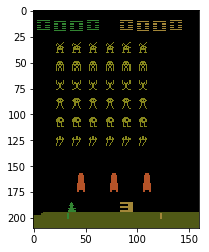

In [3]:
env.reset()
img, _, _, _ = env.step(possible_actions[0])
plt.imshow(img)

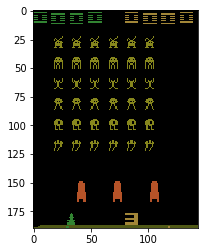

In [4]:
plt.imshow(img[8:-12,4:-12])

In [5]:
def preprocess_frame(frame):
    # grayscale
    frame = rgb2gray(frame)
    # [up: down, left: right]
    frame = frame[8:-12,4:-12]
    # normalize
    frame = frame / 255.0
    # resized [110x84x1]
    frame = transform.resize(frame, [110, 84])
    
    return frame

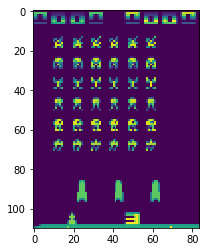

In [6]:
plt.imshow(preprocess_frame(img))

In [7]:
stack_size = 4
stacked_frames = deque([np.zeros((110, 84), dtype=np.int) for i in range(stack_size)], maxlen=stack_size)

def stack_frames(stacked_frames, state, is_new_episode):
    frame = preprocess_frame(state)
    if is_new_episode:    
        # clear the stack
        stacked_frames = deque([np.zeros((110, 84), dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
        
        for _ in range(stack_size):
            stacked_frames.append(frame)
            
        # stack the frames
    else:
        stacked_frames.append(frame)
        
    stacked_state = np.stack(stacked_frames, axis=2)
    
    return stacked_state, stacked_frames
        
    # stacked_state is 110x84x4 NUMPY ARRAY
    
            

In [10]:
# MODEL HYPERPARAMETERS
state_size = [110, 84, 4]
action_size = env.action_space.n
learning_rate = 0.00025

# TRAINING HYPERPARAMETERS
total_episodes = 50
max_steps = 50000
batch_size = 64

# EXPLORATION PARAMETERS FOR EPSILON GREEDY
explore_start = 1.0  # exploration probabilty at start
explore_stop = 0.01  # minimum exploration probability
decay_rate = 0.00001 # exponential decay rate for exploration prob

# Q-LEARNING HYPERPARAMETERS
gamma = 0.9          # discounting rate

# MEMORY HYPERPARAMETERS
pretrain_length = batch_size
memory_size = 5000 # 1000000 pojede ceo ram

stack_size = 4
training = True
episode_render = False

In [8]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            # create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.float32, [None, action_size], name='actions_')
            self.target_Q = tf.placeholder(tf.float32, [None], name='target')

            #----> CONV LAYER 1
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_, \
                                          filters = 32,\
                                          kernel_size = [8, 8], \
                                          strides = [4, 4], \
                                          padding = 'VALID', \
                                          kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(), \
                                          name = 'conv1')

            self.conv1_batchnorm = tf.layers.batch_normalization(\
                                          self.conv1, \
                                          training = True, \
                                          epsilon = 1e-5, \
                                          name = 'batch_norm1')
            
            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name='conv1_out') 

            #----> CONV LAYER 2
            # Input is conv1_out
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out, \
                                          filters = 64,\
                                          kernel_size = [4, 4], \
                                          strides = [2, 2], \
                                          padding = 'VALID', \
                                          kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(), \
                                          name = 'conv2')

            self.conv2_batchnorm = tf.layers.batch_normalization(\
                                          self.conv2, \
                                          training = True, \
                                          epsilon = 1e-5, \
                                          name = 'batch_norm2')
            
            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name='conv2_out') 


            #----> CONV LAYER 3
            # Input is conv2_out
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out, \
                                          filters = 64,\
                                          kernel_size = [3, 3], \
                                          strides = [2, 2], \
                                          padding = 'VALID', \
                                          kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(), \
                                          name = 'conv3')

            self.conv3_batchnorm = tf.layers.batch_normalization(\
                                          self.conv3, \
                                          training = True, \
                                          epsilon = 1e-5, \
                                          name = 'batch_norm3')
            
            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name='conv3_out') 


            # Flatten layer -->
            # Input is conv3_out
            self.flatten = tf.layers.flatten(self.conv3_out)
            
            # Dense layer
            # Input is flattened conv3_out
            self.fc =  tf.layers.dense(inputs = self.flatten, \
                                       units = 512, \
                                       activation = tf.nn.elu, \
                                       kernel_initializer = tf.contrib.layers.xavier_initializer(), \
                                       name = 'fc1' )

            # Output layer [Q values for each action]
            self.output =  tf.layers.dense(\
                                       inputs = self.fc, \
                                       units = self.action_size, \
                                       activation = None, \
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())  

            # Our predicted Q-value
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            # >>> np.sum([1, 2, 3], axis=1)
            # array([6])
            # >>> np.sum([1, 2, 3], axis=0)
            # array([1, 2, 3])
            # >>> np.sum([1, 2, 3], axis=None) # default
            # 6

            # The loss is the difference between our predicted Q-values and Q_target
            # Sum(Q-Target - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [11]:
tf.reset_default_graph()
DQNetwork = DQNetwork(state_size, action_size, learning_rate)

In [18]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size), size=batch_size, replace=False)
        
        return [self.buffer[i] for i in index]

In [19]:
memory = Memory(max_size=memory_size)

for i in range(pretrain_length):
    if i == 0:
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    choice = random.randint(1, len(possible_actions)) - 1
    action = possible_actions[choice]
    next_state, reward, done, _ = env.step(action)
    #env.render()
    
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    
    if done:
        next_state = np.zeros(state.shape)
        memory.add((state, action, reward, next_state, done))
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
    else:
        memory.add((state, action, reward, next_state, done))
        state = next_state